In [1]:
# ===================================================================
#      0. Import all the desired libraries
# ===================================================================

import numpy as np
import torch
import copy
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import healpy as hp


In [2]:
# ===================================================================
#      1. REUSABLE FUNCTIONS (Data preprocessing and evaluation logic)
# ===================================================================

def transform_event_features(event_sets, angular_feature_indices):
    transformed_event_sets = []
    if not angular_feature_indices: return [events.copy() for events in event_sets]
    for events in event_sets: # Removed tqdm for cleaner integration
        if events.shape[0] == 0:
            transformed_event_sets.append(events)
            continue
        non_angular_indices = [i for i in range(events.shape[1]) if i not in angular_feature_indices]
        new_feature_parts = [events[:, non_angular_indices]]
        for idx in angular_feature_indices:
            angles_rad = np.deg2rad(events[:, idx])
            new_feature_parts.extend([np.cos(angles_rad)[:, np.newaxis], np.sin(angles_rad)[:, np.newaxis]])
        transformed_events = np.concatenate(new_feature_parts, axis=1)
        transformed_event_sets.append(transformed_events)
    return transformed_event_sets

def convert_to_cartesian(coords_deg):
    lon_deg, lat_deg = coords_deg[:, 0], coords_deg[:, 1]
    lon_rad, lat_rad = np.deg2rad(lon_deg), np.deg2rad(lat_deg)
    x, y, z = np.cos(lon_rad) * np.cos(lat_rad), np.sin(lon_rad) * np.cos(lat_rad), np.sin(lat_rad)
    return np.stack([x, y, z], axis=1)

def convert_cartesian_to_lon_lat(cartesian_coords):
    x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    norms = np.sqrt(x**2 + y**2 + z**2)
    norms[norms == 0] = 1
    x, y, z = x / norms, y / norms, z / norms
    lat_rad, lon_rad = np.arcsin(z), np.arctan2(y, x)
    lat_deg, lon_deg = np.rad2deg(lat_rad), np.rad2deg(lon_rad)
    lon_deg = (lon_deg + 360) % 360
    return np.stack([lon_deg, lat_deg], axis=1)

def calculate_angular_error(y_true_cartesian, y_pred_cartesian):
    pred_norms = np.linalg.norm(y_pred_cartesian, axis=1, keepdims=True)
    pred_norms[pred_norms == 0] = 1
    y_pred_normalized = y_pred_cartesian / pred_norms
    dot_product = np.clip(np.sum(y_true_cartesian * y_pred_normalized, axis=1), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.rad2deg(angle_rad)


In [3]:
# ===================================================================
#                      2. DEEP SETS MODEL DEFINITION
# ===================================================================

class DeepSet(nn.Module):
    def __init__(self, input_dim, phi_hidden_dims, latent_dim, rho_hidden_dims, agg_type='sum'):
        super(DeepSet, self).__init__()
        
        if agg_type not in ['sum', 'mean', 'max']:
            raise ValueError("agg_type must be one of 'sum', 'mean', or 'max'")
        self.agg_type = agg_type
        
        phi_layers = [nn.Linear(input_dim, phi_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(phi_hidden_dims) - 1):
            phi_layers.extend([nn.Linear(phi_hidden_dims[i], phi_hidden_dims[i+1]), nn.ReLU()])
        phi_layers.append(nn.Linear(phi_hidden_dims[-1], latent_dim))
        self.phi = nn.Sequential(*phi_layers)
        
        rho_layers = [nn.Linear(latent_dim, rho_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(rho_hidden_dims) - 1):
            rho_layers.extend([nn.Linear(rho_hidden_dims[i], rho_hidden_dims[i+1]), nn.ReLU()])
        rho_layers.append(nn.Linear(rho_hidden_dims[-1], 3))
        self.rho = nn.Sequential(*rho_layers)

    def forward(self, x_list):
        batch_representations = []
        
        for event_set in x_list:
            if event_set.numel() == 0:
                aggregated_phi = torch.zeros(self.rho[0].in_features, device=event_set.device)
            else:
                phi_output = self.phi(event_set)
                if self.agg_type == 'sum':
                    aggregated_phi = torch.sum(phi_output, dim=0)
                elif self.agg_type == 'mean':
                    aggregated_phi = torch.mean(phi_output, dim=0)
                elif self.agg_type == 'max':
                    aggregated_phi = torch.max(phi_output, dim=0)[0]
            batch_representations.append(aggregated_phi)
        
        aggregated_batch = torch.stack(batch_representations)
        output = self.rho(aggregated_batch)
        output = output / torch.norm(output, p=2, dim=1, keepdim=True)
        return output


In [4]:
# ===================================================================
#                   3. CUSTOM DATASET AND DATALOADER
# ===================================================================

class ComptonDataset(Dataset):
    def __init__(self, x_events, y_targets, scaler=None):
        self.x_events = x_events
        self.y_targets = y_targets
        self.scaler = scaler

    def __len__(self):
        return len(self.x_events)

    def __getitem__(self, idx):
        events = self.x_events[idx]
        target = self.y_targets[idx]
        
        # Apply scaling on the fly
        if self.scaler is not None and events.shape[0] > 0:
            events = self.scaler.transform(events)
            
        return torch.FloatTensor(events), torch.FloatTensor(target)

def collate_fn(batch):
    """
    Custom collate function to handle variable-sized event sets.
    This is CRITICAL for the DataLoader.
    """
    events_list = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Targets are fixed-size, so we can stack them into a single tensor
    targets_stacked = torch.stack(targets)
    
    return events_list, targets_stacked


--- 1: Loading and Preprocessing Data ---

--- 2: Creating Data Splits and Scaler ---

--- 3: Setting up Datasets and DataLoaders ---


========================= TRAINING MODEL WITH 'SUM' AGGREGATION =========================

--- 4: Initializing Model (sum) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/100 | Train Loss: 0.666307 | Val Loss: 0.408696


Epoch 2/100 | Train Loss: 0.264377 | Val Loss: 0.140452


Epoch 3/100 | Train Loss: 0.074842 | Val Loss: 0.052345


Epoch 4/100 | Train Loss: 0.048391 | Val Loss: 0.035299


Epoch 5/100 | Train Loss: 0.038289 | Val Loss: 0.027795


Epoch 6/100 | Train Loss: 0.029460 | Val Loss: 0.032223


Epoch 7/100 | Train Loss: 0.025755 | Val Loss: 0.031458


Epoch 8/100 | Train Loss: 0.032262 | Val Loss: 0.027974


Epoch 9/100 | Train Loss: 0.029909 | Val Loss: 0.033707


Epoch 10/100 | Train Loss: 0.021534 | Val Loss: 0.022396


Epoch 11/100 | Train Loss: 0.023207 | Val Loss: 0.020797


Epoch 12/100 | Train Loss: 0.021170 | Val Loss: 0.019742


Epoch 13/100 | Train Loss: 0.018435 | Val Loss: 0.027923


Epoch 14/100 | Train Loss: 0.018890 | Val Loss: 0.022737


Epoch 15/100 | Train Loss: 0.021126 | Val Loss: 0.019116


Epoch 16/100 | Train Loss: 0.018646 | Val Loss: 0.023366


Epoch 17/100 | Train Loss: 0.019401 | Val Loss: 0.020181


Epoch 18/100 | Train Loss: 0.023348 | Val Loss: 0.020856


Epoch 19/100 | Train Loss: 0.016611 | Val Loss: 0.015209


Epoch 20/100 | Train Loss: 0.016963 | Val Loss: 0.014972


Epoch 21/100 | Train Loss: 0.016528 | Val Loss: 0.015772


Epoch 22/100 | Train Loss: 0.019088 | Val Loss: 0.015044


Epoch 23/100 | Train Loss: 0.014332 | Val Loss: 0.014580


Epoch 24/100 | Train Loss: 0.014082 | Val Loss: 0.015496


Epoch 25/100 | Train Loss: 0.014114 | Val Loss: 0.020612


Epoch 26/100 | Train Loss: 0.016268 | Val Loss: 0.016044


Epoch 27/100 | Train Loss: 0.013933 | Val Loss: 0.015800


Epoch 28/100 | Train Loss: 0.013900 | Val Loss: 0.013326


Epoch 29/100 | Train Loss: 0.014892 | Val Loss: 0.020087


Epoch 30/100 | Train Loss: 0.014588 | Val Loss: 0.014062


Epoch 31/100 | Train Loss: 0.014368 | Val Loss: 0.012719


Epoch 32/100 | Train Loss: 0.014443 | Val Loss: 0.014514


Epoch 33/100 | Train Loss: 0.011940 | Val Loss: 0.019940


Epoch 34/100 | Train Loss: 0.014097 | Val Loss: 0.017488


Epoch 35/100 | Train Loss: 0.012601 | Val Loss: 0.012947


Epoch 36/100 | Train Loss: 0.014074 | Val Loss: 0.018295


Epoch 37/100 | Train Loss: 0.013099 | Val Loss: 0.014021


Epoch 38/100 | Train Loss: 0.011805 | Val Loss: 0.014189


Epoch 39/100 | Train Loss: 0.012413 | Val Loss: 0.018555


Epoch 40/100 | Train Loss: 0.012500 | Val Loss: 0.013891


Epoch 41/100 | Train Loss: 0.012432 | Val Loss: 0.013486


Epoch 42/100 | Train Loss: 0.011725 | Val Loss: 0.016577


Epoch 43/100 | Train Loss: 0.013073 | Val Loss: 0.015265


Epoch 44/100 | Train Loss: 0.015327 | Val Loss: 0.016489


Epoch 45/100 | Train Loss: 0.013791 | Val Loss: 0.012183


Epoch 46/100 | Train Loss: 0.012106 | Val Loss: 0.015485


Epoch 47/100 | Train Loss: 0.012623 | Val Loss: 0.012476


Epoch 48/100 | Train Loss: 0.010858 | Val Loss: 0.014044


Epoch 49/100 | Train Loss: 0.011764 | Val Loss: 0.015046


Epoch 50/100 | Train Loss: 0.012753 | Val Loss: 0.014241


Epoch 51/100 | Train Loss: 0.011180 | Val Loss: 0.013359


Epoch 52/100 | Train Loss: 0.011166 | Val Loss: 0.012252


Epoch 53/100 | Train Loss: 0.012406 | Val Loss: 0.016590


Epoch 54/100 | Train Loss: 0.012134 | Val Loss: 0.014034


Epoch 55/100 | Train Loss: 0.012463 | Val Loss: 0.015889


Epoch 56/100 | Train Loss: 0.012266 | Val Loss: 0.014412


Epoch 57/100 | Train Loss: 0.010944 | Val Loss: 0.012266


Epoch 58/100 | Train Loss: 0.011116 | Val Loss: 0.014447


Epoch 59/100 | Train Loss: 0.010999 | Val Loss: 0.012478


Epoch 60/100 | Train Loss: 0.010253 | Val Loss: 0.011896


Epoch 61/100 | Train Loss: 0.010430 | Val Loss: 0.017327


Epoch 62/100 | Train Loss: 0.010825 | Val Loss: 0.012882


Epoch 63/100 | Train Loss: 0.010390 | Val Loss: 0.010870


Epoch 64/100 | Train Loss: 0.010638 | Val Loss: 0.012410


Epoch 65/100 | Train Loss: 0.010070 | Val Loss: 0.014386


Epoch 66/100 | Train Loss: 0.010582 | Val Loss: 0.012140


Epoch 67/100 | Train Loss: 0.009375 | Val Loss: 0.011423


Epoch 68/100 | Train Loss: 0.010479 | Val Loss: 0.011586


Epoch 69/100 | Train Loss: 0.010911 | Val Loss: 0.012014


Epoch 70/100 | Train Loss: 0.010797 | Val Loss: 0.012264


Epoch 71/100 | Train Loss: 0.009329 | Val Loss: 0.014444


Epoch 72/100 | Train Loss: 0.009743 | Val Loss: 0.011247


Epoch 73/100 | Train Loss: 0.010040 | Val Loss: 0.015594


Epoch 74/100 | Train Loss: 0.011147 | Val Loss: 0.010990


Epoch 75/100 | Train Loss: 0.008987 | Val Loss: 0.010624


Epoch 76/100 | Train Loss: 0.009443 | Val Loss: 0.012697


Epoch 77/100 | Train Loss: 0.009540 | Val Loss: 0.010727


Epoch 78/100 | Train Loss: 0.009198 | Val Loss: 0.011939


Epoch 79/100 | Train Loss: 0.009804 | Val Loss: 0.010622


Epoch 80/100 | Train Loss: 0.008880 | Val Loss: 0.011734


Epoch 81/100 | Train Loss: 0.008977 | Val Loss: 0.012702


Epoch 82/100 | Train Loss: 0.008671 | Val Loss: 0.018574


Epoch 83/100 | Train Loss: 0.010529 | Val Loss: 0.011371


Epoch 84/100 | Train Loss: 0.009619 | Val Loss: 0.013087


Epoch 85/100 | Train Loss: 0.010835 | Val Loss: 0.011256


Epoch 86/100 | Train Loss: 0.009179 | Val Loss: 0.012123


Epoch 87/100 | Train Loss: 0.008936 | Val Loss: 0.011953


Epoch 88/100 | Train Loss: 0.010827 | Val Loss: 0.010670


Epoch 89/100 | Train Loss: 0.009306 | Val Loss: 0.010600


Epoch 90/100 | Train Loss: 0.009678 | Val Loss: 0.012111


Epoch 91/100 | Train Loss: 0.009950 | Val Loss: 0.011877


Epoch 92/100 | Train Loss: 0.008306 | Val Loss: 0.010743


Epoch 93/100 | Train Loss: 0.008855 | Val Loss: 0.013339


Epoch 94/100 | Train Loss: 0.009010 | Val Loss: 0.011404


Epoch 95/100 | Train Loss: 0.008507 | Val Loss: 0.014217


Epoch 96/100 | Train Loss: 0.008385 | Val Loss: 0.010849


Epoch 97/100 | Train Loss: 0.007696 | Val Loss: 0.011109


Epoch 98/100 | Train Loss: 0.008477 | Val Loss: 0.010879


Epoch 99/100 | Train Loss: 0.008294 | Val Loss: 0.009821


Epoch 100/100 | Train Loss: 0.008147 | Val Loss: 0.011163

--- Training Complete for 'sum' model. Best epoch: 99 (Val Loss: 0.009821) ---

--- 6: Displaying Loss Curve Plot for 'sum' model ---


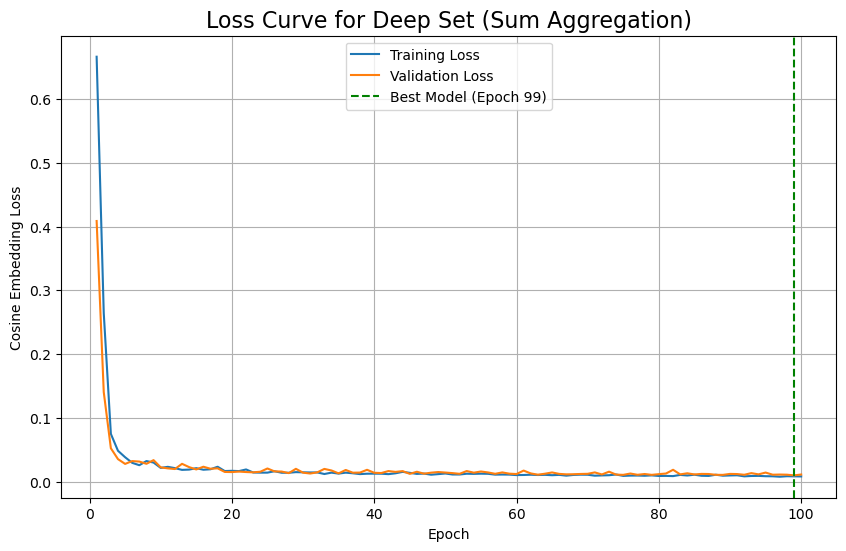


--- 7: Evaluating Best 'sum' Model on Test Set ---


Evaluating (sum): 100%|██████████| 16/16 [00:00<00:00, 23.01it/s]


Saved error vs events plot to 'error_vs_events_sum.png'


========================= TRAINING MODEL WITH 'MAX' AGGREGATION =========================

--- 4: Initializing Model (max) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/100 | Train Loss: 0.957685 | Val Loss: 0.790862


Epoch 2/100 | Train Loss: 0.612001 | Val Loss: 0.562587


Epoch 3/100 | Train Loss: 0.555620 | Val Loss: 0.529107


Epoch 4/100 | Train Loss: 0.529283 | Val Loss: 0.547045


Epoch 5/100 | Train Loss: 0.552997 | Val Loss: 0.692993


Epoch 6/100 | Train Loss: 0.538531 | Val Loss: 0.501860


Epoch 7/100 | Train Loss: 0.465680 | Val Loss: 0.430453


Epoch 8/100 | Train Loss: 0.285371 | Val Loss: 0.200583


Epoch 9/100 | Train Loss: 0.133817 | Val Loss: 0.112265


Epoch 10/100 | Train Loss: 0.075569 | Val Loss: 0.065357


Epoch 11/100 | Train Loss: 0.055460 | Val Loss: 0.072161


Epoch 12/100 | Train Loss: 0.047665 | Val Loss: 0.051108


Epoch 13/100 | Train Loss: 0.040224 | Val Loss: 0.048311


Epoch 14/100 | Train Loss: 0.038584 | Val Loss: 0.042354


Epoch 15/100 | Train Loss: 0.031626 | Val Loss: 0.038863


Epoch 16/100 | Train Loss: 0.027374 | Val Loss: 0.041019


Epoch 17/100 | Train Loss: 0.027275 | Val Loss: 0.039102


Epoch 18/100 | Train Loss: 0.022900 | Val Loss: 0.034061


Epoch 19/100 | Train Loss: 0.022190 | Val Loss: 0.038966


Epoch 20/100 | Train Loss: 0.020232 | Val Loss: 0.035483


Epoch 21/100 | Train Loss: 0.018024 | Val Loss: 0.032736


Epoch 22/100 | Train Loss: 0.018869 | Val Loss: 0.036180


Epoch 23/100 | Train Loss: 0.017498 | Val Loss: 0.029948


Epoch 24/100 | Train Loss: 0.015375 | Val Loss: 0.032201


Epoch 25/100 | Train Loss: 0.015689 | Val Loss: 0.030148


Epoch 26/100 | Train Loss: 0.016727 | Val Loss: 0.029443


Epoch 27/100 | Train Loss: 0.013602 | Val Loss: 0.034728


Epoch 28/100 | Train Loss: 0.014502 | Val Loss: 0.030755


Epoch 29/100 | Train Loss: 0.013046 | Val Loss: 0.031937


Epoch 30/100 | Train Loss: 0.013444 | Val Loss: 0.033285


Epoch 31/100 | Train Loss: 0.011357 | Val Loss: 0.028382


Epoch 32/100 | Train Loss: 0.011661 | Val Loss: 0.028252


Epoch 33/100 | Train Loss: 0.011311 | Val Loss: 0.033399


Epoch 34/100 | Train Loss: 0.011000 | Val Loss: 0.032529


Epoch 35/100 | Train Loss: 0.011526 | Val Loss: 0.030447


Epoch 36/100 | Train Loss: 0.009349 | Val Loss: 0.028971


Epoch 37/100 | Train Loss: 0.008257 | Val Loss: 0.030773


Epoch 38/100 | Train Loss: 0.008863 | Val Loss: 0.028745


Epoch 39/100 | Train Loss: 0.009397 | Val Loss: 0.027309


Epoch 40/100 | Train Loss: 0.008257 | Val Loss: 0.027565


Epoch 41/100 | Train Loss: 0.008403 | Val Loss: 0.026841


Epoch 42/100 | Train Loss: 0.008890 | Val Loss: 0.028055


Epoch 43/100 | Train Loss: 0.008631 | Val Loss: 0.031957


Epoch 44/100 | Train Loss: 0.008477 | Val Loss: 0.029380


Epoch 45/100 | Train Loss: 0.007039 | Val Loss: 0.029292


Epoch 46/100 | Train Loss: 0.007160 | Val Loss: 0.027603


Epoch 47/100 | Train Loss: 0.006592 | Val Loss: 0.025982


Epoch 48/100 | Train Loss: 0.005398 | Val Loss: 0.027401


Epoch 49/100 | Train Loss: 0.005286 | Val Loss: 0.028863


Epoch 50/100 | Train Loss: 0.006964 | Val Loss: 0.029349


Epoch 51/100 | Train Loss: 0.007602 | Val Loss: 0.026586


Epoch 52/100 | Train Loss: 0.005347 | Val Loss: 0.026008


Epoch 53/100 | Train Loss: 0.005463 | Val Loss: 0.026460


Epoch 54/100 | Train Loss: 0.007882 | Val Loss: 0.026935


Epoch 55/100 | Train Loss: 0.004815 | Val Loss: 0.025767


Epoch 56/100 | Train Loss: 0.004777 | Val Loss: 0.026194


Epoch 57/100 | Train Loss: 0.005332 | Val Loss: 0.026184


Epoch 58/100 | Train Loss: 0.004019 | Val Loss: 0.027592


Epoch 59/100 | Train Loss: 0.004365 | Val Loss: 0.026043


Epoch 60/100 | Train Loss: 0.004237 | Val Loss: 0.025752


Epoch 61/100 | Train Loss: 0.006545 | Val Loss: 0.028273


Epoch 62/100 | Train Loss: 0.005156 | Val Loss: 0.028128


Epoch 63/100 | Train Loss: 0.004663 | Val Loss: 0.028263


Epoch 64/100 | Train Loss: 0.004500 | Val Loss: 0.027203


Epoch 65/100 | Train Loss: 0.003988 | Val Loss: 0.028654


Epoch 66/100 | Train Loss: 0.003923 | Val Loss: 0.026044


Epoch 67/100 | Train Loss: 0.003529 | Val Loss: 0.025710


Epoch 68/100 | Train Loss: 0.003079 | Val Loss: 0.025549


Epoch 69/100 | Train Loss: 0.003543 | Val Loss: 0.025285


Epoch 70/100 | Train Loss: 0.002949 | Val Loss: 0.024978


Epoch 71/100 | Train Loss: 0.002932 | Val Loss: 0.025394


Epoch 72/100 | Train Loss: 0.002745 | Val Loss: 0.025714


Epoch 73/100 | Train Loss: 0.002808 | Val Loss: 0.026351


Epoch 74/100 | Train Loss: 0.004053 | Val Loss: 0.026532


Epoch 75/100 | Train Loss: 0.003848 | Val Loss: 0.026099


Epoch 76/100 | Train Loss: 0.002621 | Val Loss: 0.025088


Epoch 77/100 | Train Loss: 0.002697 | Val Loss: 0.025859


Epoch 78/100 | Train Loss: 0.002685 | Val Loss: 0.026985


Epoch 79/100 | Train Loss: 0.002729 | Val Loss: 0.025155


Epoch 80/100 | Train Loss: 0.002312 | Val Loss: 0.026343


Epoch 81/100 | Train Loss: 0.002404 | Val Loss: 0.024923


Epoch 82/100 | Train Loss: 0.002313 | Val Loss: 0.025719


Epoch 83/100 | Train Loss: 0.002318 | Val Loss: 0.026842


Epoch 84/100 | Train Loss: 0.001983 | Val Loss: 0.025325


Epoch 85/100 | Train Loss: 0.002468 | Val Loss: 0.024934


Epoch 86/100 | Train Loss: 0.002801 | Val Loss: 0.025689


Epoch 87/100 | Train Loss: 0.002770 | Val Loss: 0.027116


Epoch 88/100 | Train Loss: 0.003157 | Val Loss: 0.027568


Epoch 89/100 | Train Loss: 0.002119 | Val Loss: 0.025048


Epoch 90/100 | Train Loss: 0.002425 | Val Loss: 0.025492


Epoch 91/100 | Train Loss: 0.002019 | Val Loss: 0.026681


Epoch 92/100 | Train Loss: 0.001654 | Val Loss: 0.024607


Epoch 93/100 | Train Loss: 0.002128 | Val Loss: 0.024647


Epoch 94/100 | Train Loss: 0.001819 | Val Loss: 0.024749


Epoch 95/100 | Train Loss: 0.001698 | Val Loss: 0.026945


Epoch 96/100 | Train Loss: 0.002243 | Val Loss: 0.024785


Epoch 97/100 | Train Loss: 0.001504 | Val Loss: 0.024427


Epoch 98/100 | Train Loss: 0.001897 | Val Loss: 0.024764


Epoch 99/100 | Train Loss: 0.001515 | Val Loss: 0.024232


Epoch 100/100 | Train Loss: 0.001464 | Val Loss: 0.024704

--- Training Complete for 'max' model. Best epoch: 99 (Val Loss: 0.024232) ---

--- 6: Displaying Loss Curve Plot for 'max' model ---


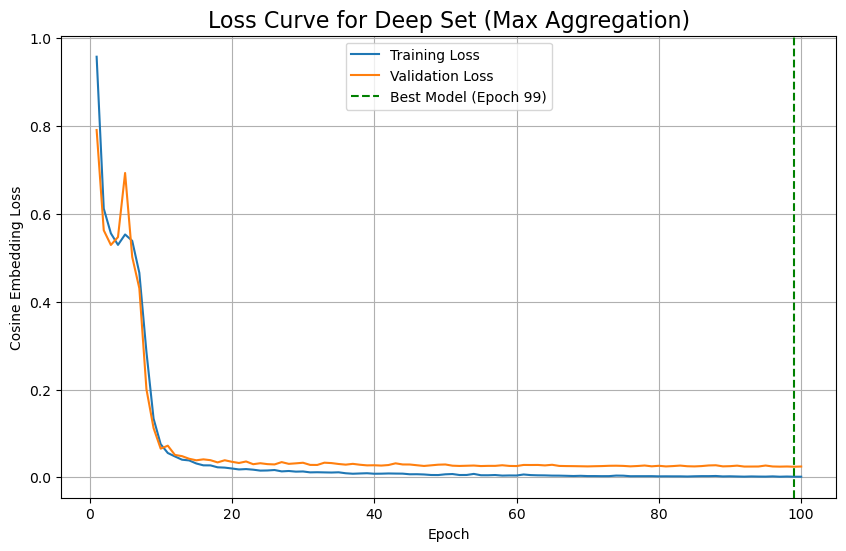


--- 7: Evaluating Best 'max' Model on Test Set ---


Evaluating (max): 100%|██████████| 16/16 [00:00<00:00, 23.52it/s]


Saved error vs events plot to 'error_vs_events_max.png'


========================= TRAINING MODEL WITH 'MEAN' AGGREGATION =========================

--- 4: Initializing Model (mean) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/100 | Train Loss: 0.990441 | Val Loss: 0.908112


Epoch 2/100 | Train Loss: 0.671840 | Val Loss: 0.523629


Epoch 3/100 | Train Loss: 0.495399 | Val Loss: 0.490091


Epoch 4/100 | Train Loss: 0.471052 | Val Loss: 0.458708


Epoch 5/100 | Train Loss: 0.366625 | Val Loss: 0.324200


Epoch 6/100 | Train Loss: 0.259692 | Val Loss: 0.261308


Epoch 7/100 | Train Loss: 0.237305 | Val Loss: 0.220233


Epoch 8/100 | Train Loss: 0.129953 | Val Loss: 0.078104


Epoch 9/100 | Train Loss: 0.055826 | Val Loss: 0.041844


Epoch 10/100 | Train Loss: 0.042247 | Val Loss: 0.036996


Epoch 11/100 | Train Loss: 0.033682 | Val Loss: 0.033315


Epoch 12/100 | Train Loss: 0.033706 | Val Loss: 0.033907


Epoch 13/100 | Train Loss: 0.029579 | Val Loss: 0.031072


Epoch 14/100 | Train Loss: 0.029134 | Val Loss: 0.045189


Epoch 15/100 | Train Loss: 0.029035 | Val Loss: 0.026859


Epoch 16/100 | Train Loss: 0.027118 | Val Loss: 0.041462


Epoch 17/100 | Train Loss: 0.026696 | Val Loss: 0.030765


Epoch 18/100 | Train Loss: 0.024494 | Val Loss: 0.032498


Epoch 19/100 | Train Loss: 0.026629 | Val Loss: 0.026695


Epoch 20/100 | Train Loss: 0.022546 | Val Loss: 0.025379


Epoch 21/100 | Train Loss: 0.021977 | Val Loss: 0.034943


Epoch 22/100 | Train Loss: 0.023766 | Val Loss: 0.024904


Epoch 23/100 | Train Loss: 0.020443 | Val Loss: 0.021032


Epoch 24/100 | Train Loss: 0.019196 | Val Loss: 0.019130


Epoch 25/100 | Train Loss: 0.018036 | Val Loss: 0.019447


Epoch 26/100 | Train Loss: 0.020413 | Val Loss: 0.023359


Epoch 27/100 | Train Loss: 0.021247 | Val Loss: 0.018831


Epoch 28/100 | Train Loss: 0.016972 | Val Loss: 0.018075


Epoch 29/100 | Train Loss: 0.016656 | Val Loss: 0.021524


Epoch 30/100 | Train Loss: 0.017879 | Val Loss: 0.022638


Epoch 31/100 | Train Loss: 0.017273 | Val Loss: 0.018064


Epoch 32/100 | Train Loss: 0.016148 | Val Loss: 0.017647


Epoch 33/100 | Train Loss: 0.016608 | Val Loss: 0.017210


Epoch 34/100 | Train Loss: 0.017331 | Val Loss: 0.023754


Epoch 35/100 | Train Loss: 0.017115 | Val Loss: 0.017272


Epoch 36/100 | Train Loss: 0.017002 | Val Loss: 0.019898


Epoch 37/100 | Train Loss: 0.016811 | Val Loss: 0.017124


Epoch 38/100 | Train Loss: 0.016323 | Val Loss: 0.018472


Epoch 39/100 | Train Loss: 0.016090 | Val Loss: 0.019317


Epoch 40/100 | Train Loss: 0.015892 | Val Loss: 0.017572


Epoch 41/100 | Train Loss: 0.017584 | Val Loss: 0.019887


Epoch 42/100 | Train Loss: 0.015433 | Val Loss: 0.015724


Epoch 43/100 | Train Loss: 0.014975 | Val Loss: 0.017577


Epoch 44/100 | Train Loss: 0.014997 | Val Loss: 0.016489


Epoch 45/100 | Train Loss: 0.014901 | Val Loss: 0.015605


Epoch 46/100 | Train Loss: 0.017456 | Val Loss: 0.017599


Epoch 47/100 | Train Loss: 0.014617 | Val Loss: 0.015089


Epoch 48/100 | Train Loss: 0.015082 | Val Loss: 0.016033


Epoch 49/100 | Train Loss: 0.014035 | Val Loss: 0.019730


Epoch 50/100 | Train Loss: 0.014897 | Val Loss: 0.015759


Epoch 51/100 | Train Loss: 0.015147 | Val Loss: 0.016610


Epoch 52/100 | Train Loss: 0.014428 | Val Loss: 0.017537


Epoch 53/100 | Train Loss: 0.015174 | Val Loss: 0.015639


Epoch 54/100 | Train Loss: 0.014961 | Val Loss: 0.018382


Epoch 55/100 | Train Loss: 0.014243 | Val Loss: 0.016181


Epoch 56/100 | Train Loss: 0.013531 | Val Loss: 0.014757


Epoch 57/100 | Train Loss: 0.013586 | Val Loss: 0.014188


Epoch 58/100 | Train Loss: 0.014210 | Val Loss: 0.017547


Epoch 59/100 | Train Loss: 0.014560 | Val Loss: 0.014337


Epoch 60/100 | Train Loss: 0.013114 | Val Loss: 0.014287


Epoch 61/100 | Train Loss: 0.013924 | Val Loss: 0.018647


Epoch 62/100 | Train Loss: 0.014304 | Val Loss: 0.013730


Epoch 63/100 | Train Loss: 0.015580 | Val Loss: 0.014081


Epoch 64/100 | Train Loss: 0.014002 | Val Loss: 0.017575


Epoch 65/100 | Train Loss: 0.013048 | Val Loss: 0.017640


Epoch 66/100 | Train Loss: 0.012697 | Val Loss: 0.015809


Epoch 67/100 | Train Loss: 0.012600 | Val Loss: 0.013641


Epoch 68/100 | Train Loss: 0.014016 | Val Loss: 0.014701


Epoch 69/100 | Train Loss: 0.012739 | Val Loss: 0.013751


Epoch 70/100 | Train Loss: 0.013426 | Val Loss: 0.014746


Epoch 71/100 | Train Loss: 0.013813 | Val Loss: 0.015477


Epoch 72/100 | Train Loss: 0.014334 | Val Loss: 0.014074


Epoch 73/100 | Train Loss: 0.014411 | Val Loss: 0.013768


Epoch 74/100 | Train Loss: 0.013512 | Val Loss: 0.016910


Epoch 75/100 | Train Loss: 0.014317 | Val Loss: 0.015343


Epoch 76/100 | Train Loss: 0.012973 | Val Loss: 0.014573


Epoch 77/100 | Train Loss: 0.012671 | Val Loss: 0.013642


Epoch 78/100 | Train Loss: 0.014011 | Val Loss: 0.018895


Epoch 79/100 | Train Loss: 0.013116 | Val Loss: 0.014185


Epoch 80/100 | Train Loss: 0.012984 | Val Loss: 0.015905


Epoch 81/100 | Train Loss: 0.014006 | Val Loss: 0.016464


Epoch 82/100 | Train Loss: 0.013190 | Val Loss: 0.013237


Epoch 83/100 | Train Loss: 0.011539 | Val Loss: 0.013351


Epoch 84/100 | Train Loss: 0.012404 | Val Loss: 0.014253


Epoch 85/100 | Train Loss: 0.011941 | Val Loss: 0.013315


Epoch 86/100 | Train Loss: 0.012510 | Val Loss: 0.012676


Epoch 87/100 | Train Loss: 0.011192 | Val Loss: 0.013986


Epoch 88/100 | Train Loss: 0.012230 | Val Loss: 0.015125


Epoch 89/100 | Train Loss: 0.011434 | Val Loss: 0.015839


Epoch 90/100 | Train Loss: 0.011606 | Val Loss: 0.014269


Epoch 91/100 | Train Loss: 0.011100 | Val Loss: 0.016151


Epoch 92/100 | Train Loss: 0.011934 | Val Loss: 0.012560


Epoch 93/100 | Train Loss: 0.011445 | Val Loss: 0.015488


Epoch 94/100 | Train Loss: 0.012545 | Val Loss: 0.012647


Epoch 95/100 | Train Loss: 0.011882 | Val Loss: 0.013241


Epoch 96/100 | Train Loss: 0.011044 | Val Loss: 0.013728


Epoch 97/100 | Train Loss: 0.011639 | Val Loss: 0.013472


Epoch 98/100 | Train Loss: 0.011661 | Val Loss: 0.014126


Epoch 99/100 | Train Loss: 0.011773 | Val Loss: 0.012234


Epoch 100/100 | Train Loss: 0.011588 | Val Loss: 0.014938

--- Training Complete for 'mean' model. Best epoch: 99 (Val Loss: 0.012234) ---

--- 6: Displaying Loss Curve Plot for 'mean' model ---


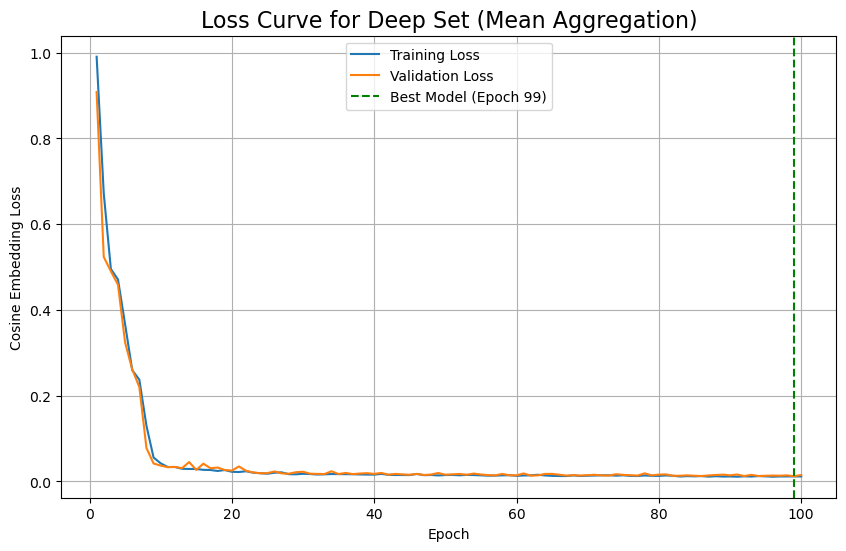


--- 7: Evaluating Best 'mean' Model on Test Set ---


Evaluating (mean): 100%|██████████| 16/16 [00:00<00:00, 27.04it/s]


Saved error vs events plot to 'error_vs_events_mean.png'


============================== FINAL RESULTS SUMMARY ==============================

--- Model Performance on Test Set ---
Model                     Mean Angular Error        Median Angular Error     
---------------------------------------------------------------------------
Deep Sets (Sum)           5.9915 degrees            4.1169 degrees           
Deep Sets (Max)           10.1203 degrees           8.4940 degrees           
Deep Sets (Mean)          6.5867 degrees            4.8449 degrees           
LMMLEM (Baseline)         6.6815                    degrees 0.7193                    degrees

--- Detailed Sample Predictions (l, b in degrees) ---

----------- Sample 1 -----------
  - Ground Truth        : ( 127.16,  21.47)
  - LMMLEM Pred         : ( 127.50,  22.50) -> Error: 1.08°
  - Deep Sets (Sum)     : ( 122.16,  27.32) -> Error: 7.41°
  - Deep Sets (Max)     : ( 129.51,  22.69) -> Error: 2.50°
  - Deep Sets (Mean)   

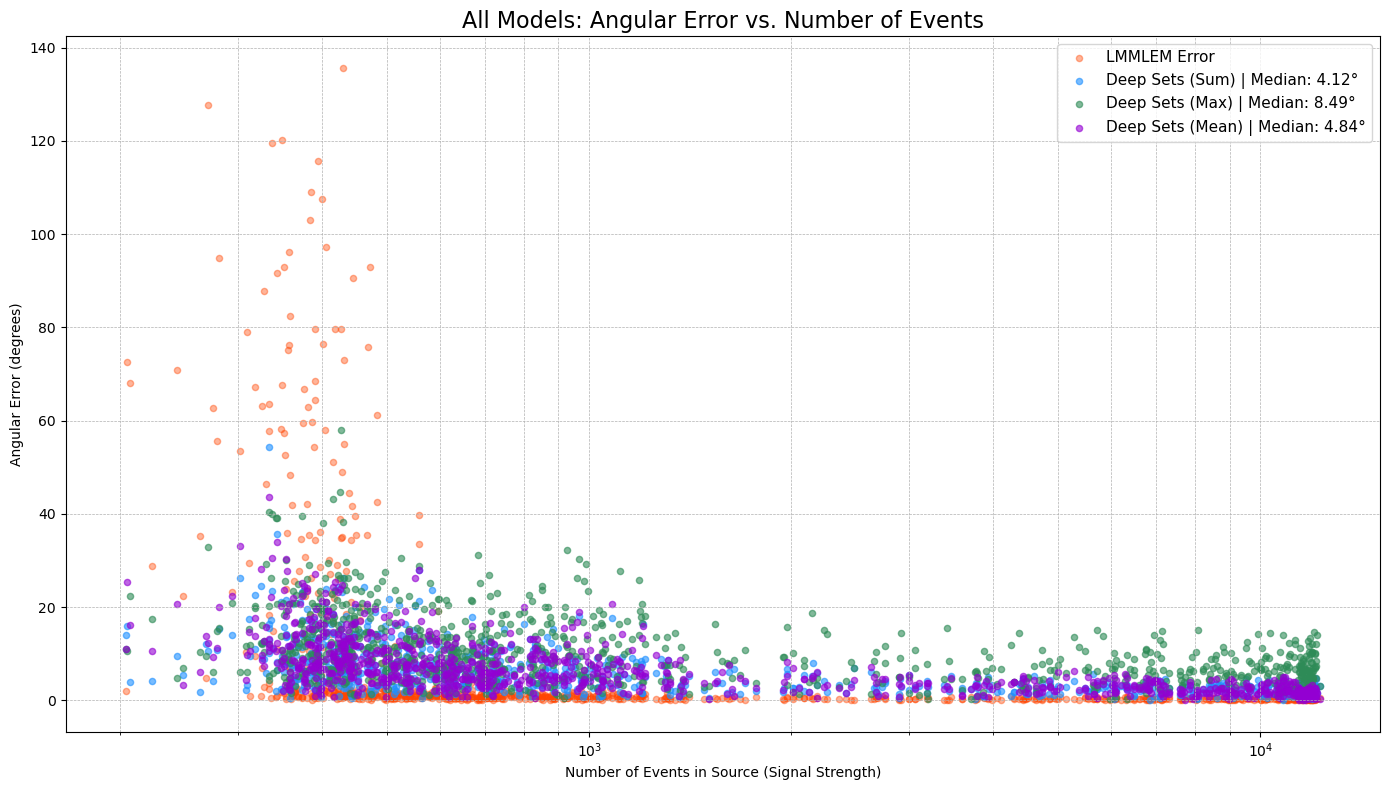

In [5]:
# ===================================================================
#                        4. MAIN SCRIPT
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    ANGULAR_FEATURE_INDICES = [1, 3, 4] 
    PHI_HIDDEN_DIMS = [128, 256, 512]
    LATENT_DIM = 1024
    RHO_HIDDEN_DIMS = [512, 256, 128, 64]
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 64
    EPOCHS = 100
    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
    AGGREGATION_TYPES = ['sum', 'max', 'mean']

    # --- 1. Load and Preprocess Data ---
    print("--- 1: Loading and Preprocessing Data ---")
    x_events_raw = np.load("./All_Events_SignalBkg5_Deg.npy", allow_pickle=True)
    y_coords = np.load("./Ground_Truths.npy", allow_pickle=True)
    y_lon_lat_deg_true = np.array(y_coords[:, 1:3], dtype=np.float32)
    y_lon_lat_deg_lmmlem = np.array(y_coords[:, 3:5], dtype=np.float32)
    
    x_events_transformed = transform_event_features(x_events_raw, ANGULAR_FEATURE_INDICES)
    y_cartesian_true = convert_to_cartesian(y_lon_lat_deg_true)
    
    # --- 2. Create Splits and Fit Scaler ---
    print("\n--- 2: Creating Data Splits and Scaler ---")
    x_raw_train_val, x_raw_test, x_train_val, x_test, y_train_val, y_test, y_train_val_lb, y_test_lb, y_lmmlem_train_val, y_lmmlem_test = train_test_split(
        x_events_raw, x_events_transformed, y_cartesian_true, y_lon_lat_deg_true, y_lon_lat_deg_lmmlem,
        test_size=0.2, random_state=42)
    x_raw_train, x_raw_val, x_train, x_val, y_train, y_val, y_train_lb, y_val_lb, y_lmmlem_train, y_lmmlem_val = train_test_split(
        x_raw_train_val, x_train_val, y_train_val, y_train_val_lb, y_lmmlem_train_val,
        test_size=0.2, random_state=42)
    
    all_train_events = np.concatenate([events for events in x_train if events.shape[0] > 0])
    scaler = StandardScaler()
    scaler.fit(all_train_events)
    
    # --- 3. Create Datasets and DataLoaders ---
    print("\n--- 3: Setting up Datasets and DataLoaders ---")
    train_dataset = ComptonDataset(x_train, y_train, scaler)
    val_dataset = ComptonDataset(x_val, y_val, scaler)
    test_dataset = ComptonDataset(x_test, y_test, scaler)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    all_results = {}

    for agg_type in AGGREGATION_TYPES:
        print(f"\n\n{'='*25} TRAINING MODEL WITH '{agg_type.upper()}' AGGREGATION {'='*25}")

        # --- 4. Initialize Model ---
        print(f"\n--- 4: Initializing Model ({agg_type}) and Training Components ---")
        input_dim = all_train_events.shape[1]
        model = DeepSet(input_dim=input_dim, phi_hidden_dims=PHI_HIDDEN_DIMS, latent_dim=LATENT_DIM, rho_hidden_dims=RHO_HIDDEN_DIMS, agg_type=agg_type).to(DEVICE)
        criterion = nn.CosineEmbeddingLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print(f"Using device: {DEVICE}")
        
        # --- 5. Training Loop with Validation ---
        print("\n--- 5: Starting Training with Validation ---")
        train_losses, val_losses = [], []
        best_val_loss, best_epoch, best_model_state_dict = float('inf'), -1, None
        
        for epoch in range(EPOCHS):
            # --- Training Phase ---
            model.train()
            running_train_loss = 0.0
            # Use leave=False for a cleaner output
            for events_list, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False):
                events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(events_list)
                loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # --- Validation Phase ---
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                # Use leave=False for a cleaner output
                for events_list, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]  ", leave=False):
                    events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                    outputs = model(events_list)
                    loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                    running_val_loss += loss.item()
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)

            # --- Print Epoch Results on a Single Line ---
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

            # --- Check for Best Model ---
            if epoch_val_loss < best_val_loss:
                best_val_loss, best_epoch, best_model_state_dict = epoch_val_loss, epoch + 1, copy.deepcopy(model.state_dict())
        
        print(f"\n--- Training Complete for '{agg_type}' model. Best epoch: {best_epoch} (Val Loss: {best_val_loss:.6f}) ---")

        # --- 6. Plot Loss Curves Directly ---
        print(f"\n--- 6: Displaying Loss Curve Plot for '{agg_type}' model ---")
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
        plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label=f'Best Model (Epoch {best_epoch})')
        plt.title(f'Loss Curve for Deep Set ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Epoch'), plt.ylabel('Cosine Embedding Loss'), plt.legend(), plt.grid(True)
        plt.show() # This will display the plot and pause execution until it's closed

        # --- 7. Evaluation on Test Set ---
        print(f"\n--- 7: Evaluating Best '{agg_type}' Model on Test Set ---")
        if best_model_state_dict: model.load_state_dict(best_model_state_dict)
        model.eval()
        all_preds_cart, all_targets_cart = [], []
        with torch.no_grad():
            for events_list, targets in tqdm(test_loader, desc=f"Evaluating ({agg_type})"):
                events_list = [e.to(DEVICE) for e in events_list]
                all_preds_cart.append(model(events_list).cpu().numpy())
                all_targets_cart.append(targets.cpu().numpy())
        y_pred_cart_deepset = np.concatenate(all_preds_cart)
        y_true_cart_eval = np.concatenate(all_targets_cart)
        angular_errors_deepset = calculate_angular_error(y_true_cart_eval, y_pred_cart_deepset)

        all_results[agg_type] = {
            'predictions_cart': y_pred_cart_deepset,
            'errors': angular_errors_deepset,
            'mean_error': np.mean(angular_errors_deepset),
            'median_error': np.median(angular_errors_deepset)
        }
        
        # --- 8. Error vs Events Plot (Saved for later) ---
        test_event_counts = [len(events) for events in x_raw_test]
        y_pred_cart_lmmlem = convert_to_cartesian(y_lmmlem_test)
        angular_errors_lmmlem = calculate_angular_error(y_true_cart_eval, y_pred_cart_lmmlem)
        plt.figure(figsize=(12, 7))
        plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.5, s=20, label='LMMLEM Error', c='orangered')
        plt.scatter(test_event_counts, angular_errors_deepset, alpha=0.5, s=20, label=f'Deep Sets ({agg_type.capitalize()}) Error', c='dodgerblue')
        plt.title(f'Model Error vs. Events ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Number of Events'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log'), plt.legend(), plt.grid(True, which='both', linestyle='--')
        plt.savefig(f"error_vs_events_{agg_type}_100.png")
        plt.close() # Close figure to avoid displaying it now
        print(f"Saved error vs events plot to 'error_vs_events_{agg_type}.png'")


    # ===================================================================
    #              9. FINAL SUMMARY AND COMPARISONS
    # ===================================================================
    print("\n\n" + "="*30 + " FINAL RESULTS SUMMARY " + "="*30)
    
    # --- Print Summary Table ---
    print("\n--- Model Performance on Test Set ---")
    print(f"{'Model':<25} {'Mean Angular Error':<25} {'Median Angular Error':<25}")
    print("-" * 75)
    for agg_type, results in all_results.items():
        model_name = f"Deep Sets ({agg_type.capitalize()})"
        mean_err = f"{results['mean_error']:.4f} degrees"
        median_err = f"{results['median_error']:.4f} degrees"
        print(f"{model_name:<25} {mean_err:<25} {median_err:<25}")
    mean_err_lmmlem, median_err_lmmlem = np.mean(angular_errors_lmmlem), np.median(angular_errors_lmmlem)
    print(f"{'LMMLEM (Baseline)':<25} {mean_err_lmmlem:<25.4f} degrees {median_err_lmmlem:<25.4f} degrees")
    print("=" * 78)

    # --- Print Detailed Sample Predictions ---
    print("\n--- Detailed Sample Predictions (l, b in degrees) ---")
    predictions_lb_all_models = {
        agg: convert_cartesian_to_lon_lat(res['predictions_cart']) for agg, res in all_results.items()
    }
    num_samples_to_show = min(5, len(y_test_lb))
    for i in range(num_samples_to_show):
        print(f"\n----------- Sample {i+1} -----------")
        true_l, true_b = y_test_lb[i]
        print(f"  - {'Ground Truth':<20}: ({true_l:7.2f}, {true_b:6.2f})")
        
        lmmlem_l, lmmlem_b = y_lmmlem_test[i]
        lmmlem_err = angular_errors_lmmlem[i]
        print(f"  - {'LMMLEM Pred':<20}: ({lmmlem_l:7.2f}, {lmmlem_b:6.2f}) -> Error: {lmmlem_err:.2f}°")
        
        for agg_type in AGGREGATION_TYPES:
            deepset_l, deepset_b = predictions_lb_all_models[agg_type][i]
            deepset_err = all_results[agg_type]['errors'][i]
            model_name_str = f"Deep Sets ({agg_type.capitalize()})"
            print(f"  - {model_name_str:<20}: ({deepset_l:7.2f}, {deepset_b:6.2f}) -> Error: {deepset_err:.2f}°")

    # --- Create and Display Final Comparison Plot ---
    print("\n\n--- Generating Final Comparison Plot ---")
    plt.figure(figsize=(14, 8))
    colors = {'sum': 'dodgerblue', 'max': 'seagreen', 'mean': 'darkviolet'}
    plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.4, s=20, label='LMMLEM Error', c='orangered')
    for agg_type, results in all_results.items():
        plt.scatter(test_event_counts, results['errors'], alpha=0.6, s=20, 
                    label=f"Deep Sets ({agg_type.capitalize()}) | Median: {results['median_error']:.2f}°", 
                    c=colors[agg_type])
    plt.title('All Models: Angular Error vs. Number of Events', fontsize=16)
    plt.xlabel('Number of Events in Source (Signal Strength)'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log')
    plt.legend(fontsize=11), plt.grid(True, which='both', linestyle='--', linewidth=0.5), plt.tight_layout()
    plt.savefig("error_comparison_all_models_100.png")
    print("\nGenerated final comparison plot and saved as 'error_comparison_all_models.png'")
    plt.show()

In [6]:
all_train_events.shape

(10627698, 8)

In [7]:
print(min(angular_errors_lmmlem))
print(max(angular_errors_lmmlem))

0.0
135.65108


In [8]:
print(min(angular_errors_deepset))
print(max(angular_errors_deepset))

0.07912937
43.608093


In [13]:
y_lon_lat_deg_true.shape

(4993, 2)

In [14]:
y_lmmlem_test.shape

(999, 2)

In [15]:
y_test_lb.shape

(999, 2)

In [17]:
predictions_lb_all_models['sum'].shape

(999, 2)

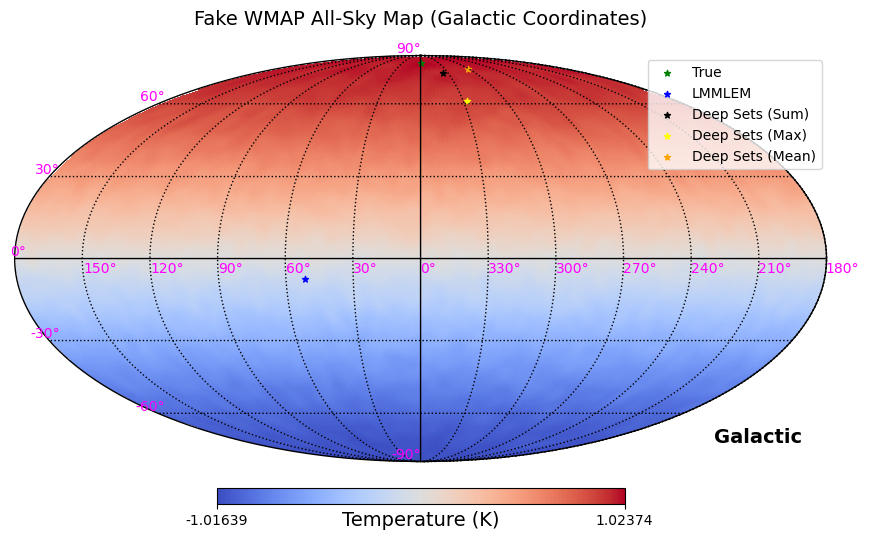

In [29]:
import healpy as hp
import matplotlib.pyplot as plt

# `healpy.visufunc` doesn't natively support graticule labels
# `healpy.newvisufunc` can plot graticule labels, but it's still an experimenting functionality (20241118), so it's better to use `healpy.visufunc` for now
# produce mock WMAP-like map
nside = 64  # Set to 64 for simplicity; higher values give finer resolution
npix = hp.nside2npix(nside)

# Create synthetic WMAP-like data
# Example: Use a sine gradient for Galactic latitude with random noise
l, b = hp.pix2ang(nside, np.arange(npix), lonlat=True)  # Longitude (l), Latitude (b)
data = np.sin(np.radians(b)) + 0.1 * np.random.randn(npix)  # Gradient + Noise

# Smooth the data to mimic WMAP features (optional)
data_smoothed = hp.smoothing(data, sigma=np.radians(2.0))  # 2-degree smoothing

# plot the healpy map
hp.mollview(data_smoothed, unit="Temperature (K)", cmap="coolwarm", coord = "G")
hp.graticule(coord = "G")

# The labels of graticule to plot
latitudes = np.arange(-90, 91, 30)  # Latitude labels in degrees
longitudes = np.arange(0, 359, 30)  # Longitude labels in degrees

# Loop through and place the labels on the plot
for lat in latitudes:
    hp.projtext(175, lat, f"{lat}°", lonlat=True, color="magenta", fontsize=10,
                horizontalalignment = "right", verticalalignment = "bottom")

for lon in longitudes:
    hp.projtext(lon, -5, f"{lon}°", lonlat=True, color="magenta", fontsize=10)

# hp.projscatter(
#     120, 30,
#     lonlat=True,
#     color="green",
#     s=120,
#     marker="*",
#     coord="G"
# )

# y_test_lb = [239.78, 34.987]

hp.projscatter(y_test_lb[1][0], y_test_lb[1][1],
               lonlat=True, color="green", s=20, marker="*", coord="G", label='True')

hp.projscatter(y_lmmlem_test[1][0], y_lmmlem_test[1][1],
               lonlat=True, color="blue", s=20, marker="*", coord="G", label='LMMLEM')

hp.projscatter(predictions_lb_all_models['sum'][1][0], predictions_lb_all_models['sum'][1][1],
               lonlat=True, color="black", s=20, marker="*", coord="G", label='Deep Sets (Sum)')

hp.projscatter(predictions_lb_all_models['max'][1][0], predictions_lb_all_models['max'][1][1],
               lonlat=True, color="yellow", s=20, marker="*", coord="G", label='Deep Sets (Max)')

hp.projscatter(predictions_lb_all_models['mean'][1][0], predictions_lb_all_models['mean'][1][1],
               lonlat=True, color="orange", s=20, marker="*", coord="G", label='Deep Sets (Mean)')

fig = plt.gcf()
ax = plt.gca()
plt.legend(loc="upper right", fontsize=10)  # choose loc as you like
# control the position of the titile, so it won't overlap the 90 deg latitude label
ax.set_title("Fake WMAP All-Sky Map (Galactic Coordinates)", fontsize=14, y=1.05)
# Save the figure
plt.savefig("wmap_sample_map_100.png", dpi=300, bbox_inches="tight")

# Optional: Show the figure
plt.show()
